In the article http://paduaresearch.cab.unipd.it/9738/1/GUIDOLINGUSEO_SETT2016.pdf , the authors investigate the dynamics of iPhone and iPad sales with differential equations. They suggest a certain system of nonlinear differential equations and fit parameters based on time-series data. Without knowledge of appropriate formula for equations, one can identify dynamics utilizing matrix Lie transform.

In [1]:
import numpy as np
import sympy as sp
from sympy import Symbol, expand
import pickle

import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import sys
sys.path.insert(0,'..')

from core.Lie import LieLayer
from core.Lie_map_builder import LieMapBuilder

Using TensorFlow backend.


First, let's define time series for sales and filter them out

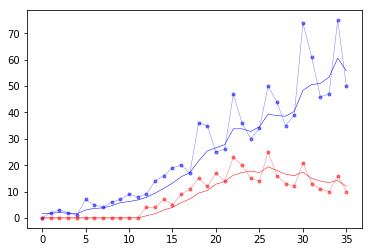

In [4]:
iPhone_raw = np.array([0, 2, 3, 2, 1, 7, 5, 4, 6, 7, 9, 8, 9,14,16,19,20,17,36,35,25,26,47,36,30,34,50,44,35,39,74,61,46,47,75,50], dtype=float)
iPad_raw =   np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 7, 5, 9,11,15,12,17,14,23,20,15,14,25,16,13,12,21,13,11,10,16,10], dtype=float)

def moving_average(x, window_len=4):
    w = np.ones(window_len)
    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    return np.convolve(w/w.sum(), s, mode='valid')

n=len(iPhone)

iPhone=moving_average(iPhone_raw, window_len=5)[:n]
iPad=moving_average(iPad_raw, window_len=5)[:n]
    
plt.plot(iPhone_raw, 'bo-', markersize=3, linewidth=0.5, alpha=0.5)
plt.plot(iPad_raw, 'ro-', markersize=3, linewidth=0.5, alpha=0.5)

plt.plot(iPhone, 'b-',linewidth=0.5)
plt.plot(iPad, 'r-', linewidth=0.5)

plt.show()

For every time stamp i we have a pair X_i=(x_i,y_i) that describes the number of sales for iPad and iPhone. The point of this example is to identify matrix Lie transform that represents this dynamics.

In [5]:
# prepare polynomial nn
inputDim = 2
outputDim = 2
order = 5
model = Sequential()
map = LieLayer(output_dim = outputDim, order=order,
               input_shape = (inputDim,))
model.add(map)
model.compile(loss='mean_squared_error', optimizer='adamax')
    
    
#prepare data
scale = 100
data = np.vstack((iPhone, iPad)).T

approx_fix_point = np.array([65, 9]) # see article for explanation
data -= approx_fix_point

data/=scale
start_dynamics = 12 # start of iPad sales
N = len(data)
model.fit(data[start_dynamics:-1], data[start_dynamics+1:], nb_epoch=6000, batch_size=20, verbose=0)

/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:622: UserWarning: Class `core.Lie.LieLayer` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)
/usr/local/lib/python2.7/dist-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Now we have a model of sales dynamics and can predict sales from any timestamp

[-0.572 -0.082]


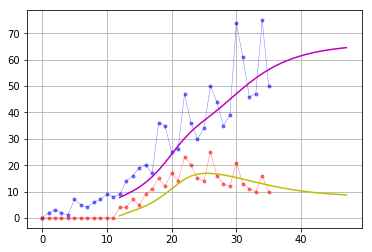

In [13]:
def iterative_predict(model, X0, N, st_size=2):
    ans = np.empty((N, st_size))
    X = X0.reshape(-1,st_size)
    for i in xrange(N):
        X = model.predict(X)
        ans[i] = X
    return np.vstack((X0, ans[:-1]))

X0 = data[start_dynamics]
print(X0)
#calculate sales starting at X0
X_predict = iterative_predict(model, X0, N)
X_predict*=scale
X_predict+=approx_fix_point

plt.plot(iPhone_raw, 'bo-', markersize=3, linewidth=0.5, alpha=0.5)
plt.plot(iPad_raw, 'ro-', markersize=3, linewidth=0.5, alpha=0.5)

plt.plot(range(start_dynamics, start_dynamics+N), X_predict[:,0], 'm-', alpha=1)
plt.plot(range(start_dynamics, start_dynamics+N), X_predict[:,1], 'y-', alpha=1)
plt.grid()
plt.show()